In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
img1 = cv2.imread('book.png',0) # queryImage
img2 = cv2.imread('books.jpg',0) # trainImage
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [3]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [4]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)


In [5]:
MIN_MATCH_COUNT = 10
print(len(good))


469


In [6]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

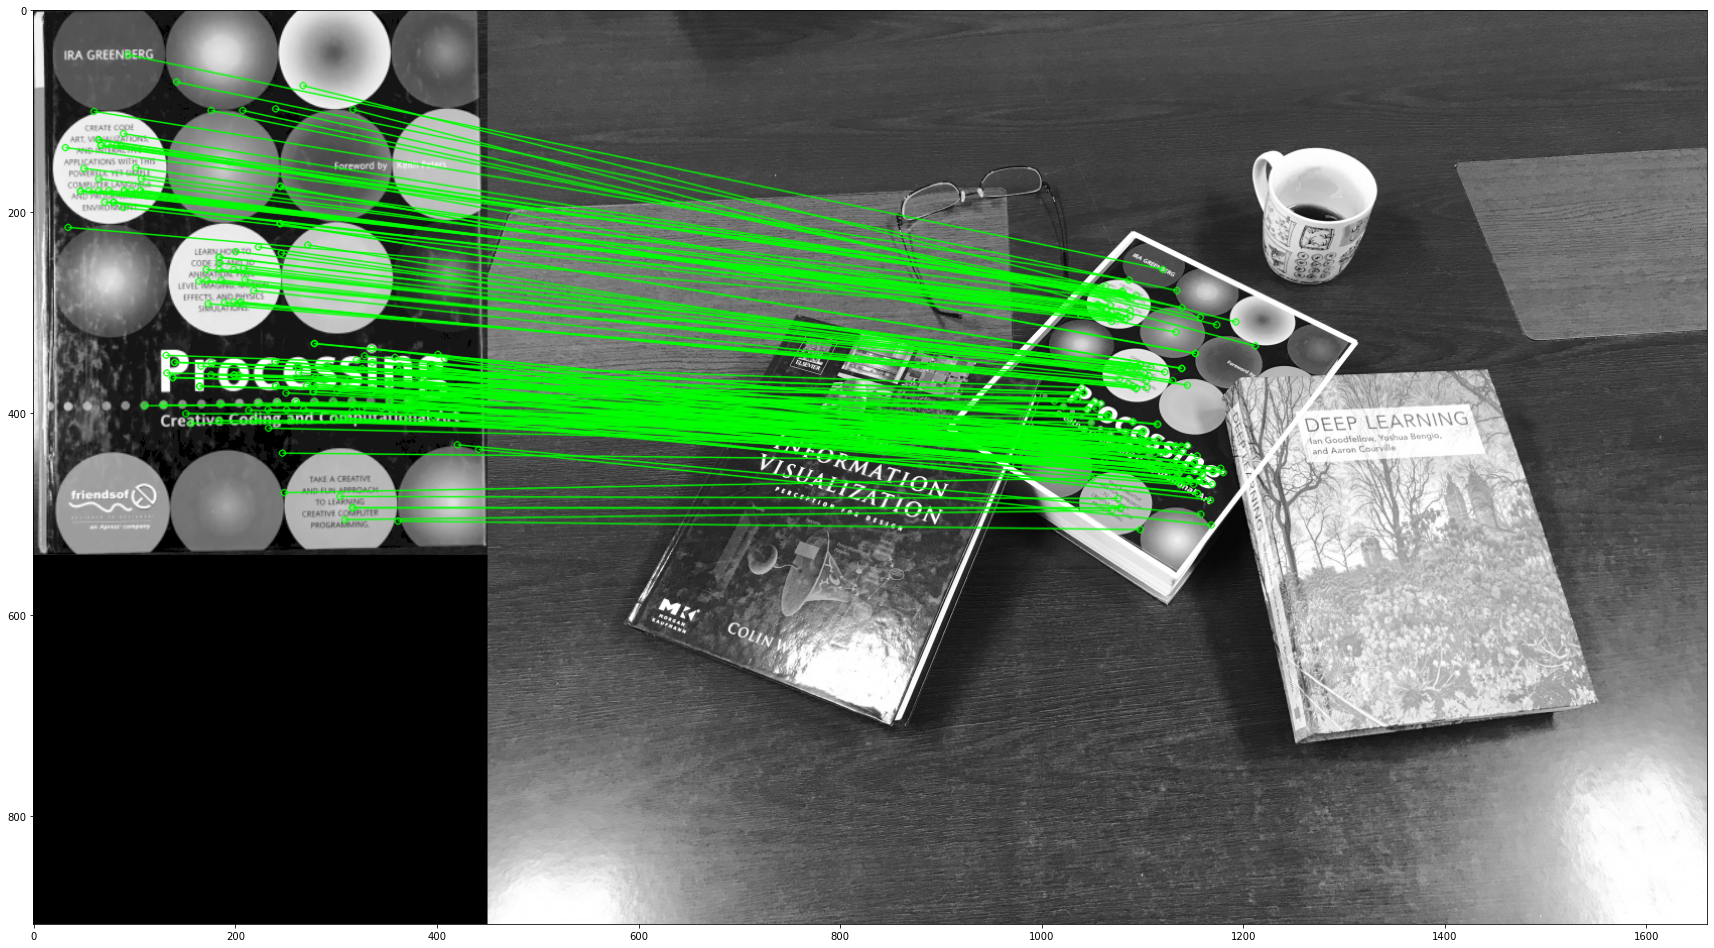

(<matplotlib.image.AxesImage at 0x217b8488760>, None)

In [7]:
draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (30,30))
plt.imshow(img3, 'gray'),plt.show()

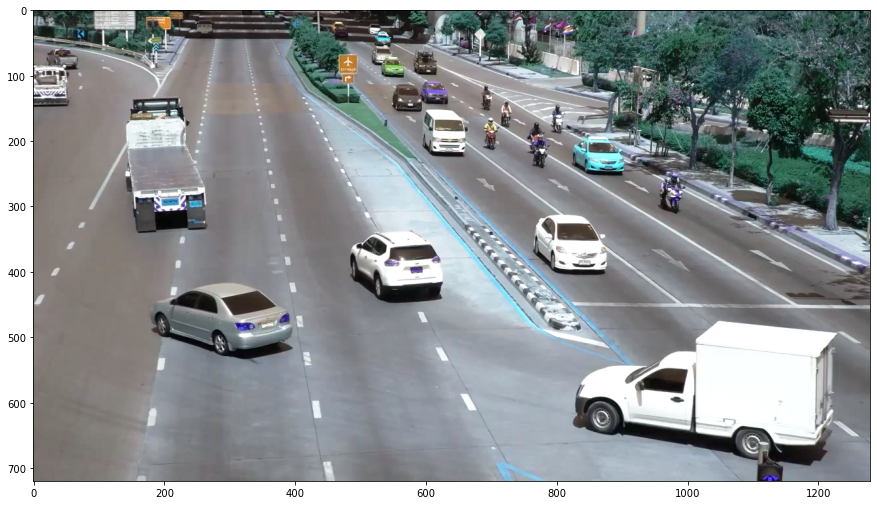

In [2]:
cap = cv2.VideoCapture('monitoring_720p.avi')
# take first frame of the video
ret,frame = cap.read()
plt.figure(figsize = (15,15))
plt.imshow(frame)
plt.show()


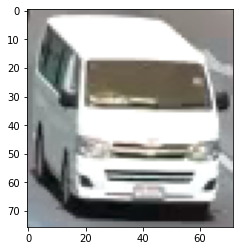

In [3]:
# setup initial location of window
r,h,c,w = 150,76,594,72 # simply hardcoded the values
track_window = (c,r,w,h)
# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
plt.imshow(roi)
plt.show()


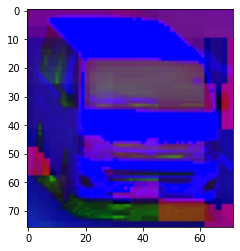

In [4]:
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
# set up the ROI for tracking
plt.imshow(hsv_roi)
plt.show()


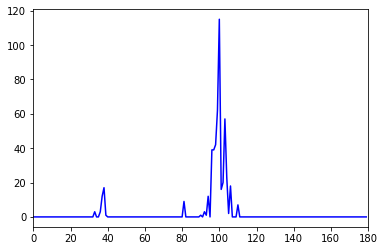

In [5]:
mask = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0,180])
plt.plot(roi_hist, color = 'b')
plt.xlim([0,180])
plt.show()


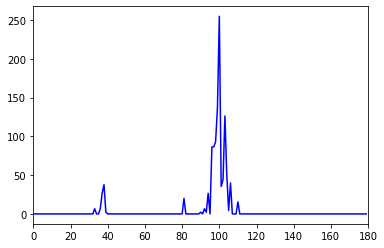

In [6]:
roi_hist = cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
plt.plot(roi_hist, color = 'b')
plt.xlim([0,180])
plt.show()


In [7]:

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
    ret ,frame = cap.read()
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
       
        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)
        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)
    else:
        break
       
cv2.destroyAllWindows()
cap.release()


In [8]:

cap = cv2.VideoCapture('monitoring_720p.avi')
cv2.namedWindow('img2')
while(1):
    ret ,frame = cap.read()
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)
    else:
        break
cv2.destroyAllWindows()
cap.release()


In [9]:

cap = cv2.VideoCapture('monitoring_720p.avi')
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100, qualityLevel = 0.3, minDistance = 7, blockSize = 7)

In [10]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize = (15,15), maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)


In [12]:
cap = cv2.VideoCapture('monitoring_720p.avi')
cv2.namedWindow('img3')
while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
   
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
   
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
   
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
 
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
cv2.destroyAllWindows()
cap.release()


In [30]:
cap = cv2.VideoCapture('monitoring_720p.avi')
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

In [12]:
while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    #rgb = cv2.resize(rgb, (640, 360))  
    #frame2 = cv2.resize(frame2, (640, 360))  
    cv2.imshow('frame1',rgb)
    cv2.imshow('frame2',frame2)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next
cap.release()
cv2.destroyAllWindows()


NameError: name 'prvs' is not defined